In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv('aggregated_hemnet.csv').drop('Unnamed: 0', axis=1)
df = df.drop('index', axis=1)

In [27]:
df.columns = ['date', 'area', 'price_sqm', 'asking_price', 'nbr_rooms',
       'living_space', 'rent', 'additional', 'year_built', 'closing_price',
       'bi_area', 'price_inc_percent']

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14521 entries, 0 to 14520
Data columns (total 12 columns):
date                 14521 non-null object
area                 14521 non-null object
price_sqm            14512 non-null float64
asking_price         14521 non-null float64
nbr_rooms            14515 non-null float64
living_space         14512 non-null float64
rent                 14503 non-null float64
additional           9488 non-null float64
year_built           13549 non-null float64
closing_price        14521 non-null int64
bi_area              321 non-null float64
price_inc_percent    14521 non-null float64
dtypes: float64(9), int64(1), object(2)
memory usage: 1.3+ MB


In [23]:
month_map = {
        'januari' : '01',
        'februari' : '02',
        'mars' : '03',
        'april': '04',
        'maj' : '05',
        'juni' : '06',
        'juli' : '07',
        'augusti' : '08',
        'september' : '09',
        'oktober' : '10',
        'november' : '11',
        'december' : '12'
    }
month_series = df.date.apply(lambda x: x[2:-4].strip(' ')).map(month_map)
day_series = df.date.apply(lambda x: '-' + x[:2] + '-')
year_series = df.date.apply(lambda x: x[-4:])
df.date = month_series+day_series+year_series
df.date = pd.to_datetime(df.date)

In [24]:
df = df.sort_values('date', ascending=False)

In [25]:
df

,date,area,price_sqm,asking_price,nbr_rooms,living_space,rent,additional,year_built,closing_price,bi_area,price_inc_percent
0,NaT,sodermalm,102500.0,3495000.0,1.0,40.0,1160.0,9500.0,1889.0,4100000,NaN,0.173104
1,NaT,kungsholmen,107955.0,1995000.0,1.0,22.0,1581.0,2800.0,1937.0,2375000,NaN,0.190476
2,NaT,vasastan,108500.0,4495000.0,2.0,50.0,550.0,3600.0,1912.0,5425000,NaN,0.206897
3,NaT,kungsholmen,103704.0,2800000.0,1.0,27.0,790.0,4164.0,1937.0,2800000,NaN,0.000000
4,NaT,lilla_essingen,62202.0,4995000.0,3.0,84.0,3689.0,5500.0,1939.0,5225000,NaN,0.046046
...,...,...,...,...,...,...,...,...,...,...,...,...
14516,NaT,lilla_essingen,47500.0,1950000.0,1.5,40.0,2269.0,3400.0,1939.0,1900000,NaN,-0.025641
14517,NaT,lilla_essingen,NaN,1650000.0,1.0,NaN,1623.0,NaN,1963.0,1800000,NaN,0.090909
14518,NaT,lilla_essingen,47500.0,1995000.0,1.5,42.0,1575.0,4152.0,1937.0,1995000,NaN,0.000000
14519,NaT,lilla_essingen,NaN,1495000.0,1.0,NaN,1158.0,NaN,1939.0,1700000,NaN,0.137124


In [372]:
df.loc[~df.Byggår.isna(),'Byggår'] = df.loc[~df.Byggår.isna(),'Byggår'].map(lambda x: x[:4])
df['Byggår'] = pd.to_numeric(df['Byggår'])

In [373]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2449 entries, 0 to 2448
Data columns (total 12 columns):
url                      2449 non-null object
Datum                    2449 non-null datetime64[ns]
Område                   2449 non-null object
Pris per kvadratmeter    2449 non-null int64
Begärt pris              2437 non-null float64
Antal rum                2448 non-null float64
Boarea                   2449 non-null float64
Avgift/månad             2444 non-null float64
Driftskostnad            1616 non-null float64
Byggår                   2239 non-null float64
Slutpris                 2449 non-null int64
Biarea                   54 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 248.7+ KB


This seems like a job for XGBoost!

In [29]:
def feature_check(X):
    cat_cols = np.array([])
    for col_name in X.columns:
        if X[col_name].dtypes == 'object':
            unique_cat = len(X[col_name].unique())
            cat_cols = np.hstack([np.array(col_name), cat_cols])
            if unique_cat > 10:
                print("Feature '{col_name}' has {unique_cat} unique categories".format(
                        col_name=col_name, unique_cat=unique_cat))
            else:
                print("Feature '{col_name}' has {unique_cat} unique categories, which are {c}".format(
                    col_name=col_name, unique_cat=unique_cat,c=X[col_name].unique()))
    return cat_cols
  
cat_cols = feature_check(df)
#X.origin_up.unique()

Feature 'date' has 1690 unique categories
Feature 'area' has 8 unique categories, which are ['sodermalm' 'kungsholmen' 'vasastan' 'lilla_essingen' 'gardet'
 'ostermalm' 'gamla_stan' 'stora_essingen']


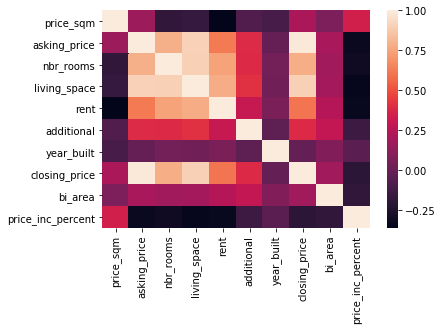

In [30]:
import seaborn as sns
sns.heatmap(df.corr())

In [32]:
df.corr()['price_sqm'].sort_values(ascending=False)

price_sqm            1.000000
price_inc_percent    0.346521
closing_price        0.213573
asking_price         0.169107
bi_area              0.075368
additional          -0.075175
year_built          -0.100974
living_space        -0.165208
nbr_rooms           -0.180821
rent                -0.358677
Name: price_sqm, dtype: float64

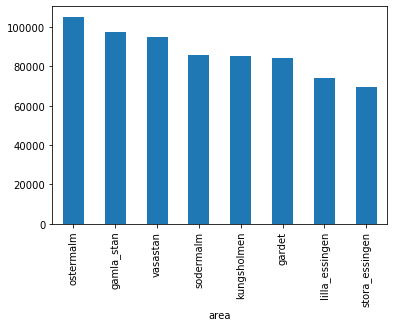

In [36]:
df.groupby('area').price_sqm.median().sort_values(ascending=False).plot.bar()

In [595]:
df['date_dt'] = pd.to_datetime(df.date)

In [601]:
df.area.value_counts()

ostermalm         2494
sodermalm         2494
vasastan          2489
kungsholmen       2489
gardet            2489
lilla_essingen    1196
stora_essingen     701
gamla_stan         169
Name: area, dtype: int64

In [614]:
price = df.loc[df.area=='vasastan'].price_sqm
price.index = df.loc[df.area=='vasastan'].date_dt

In [621]:
price = price.resample('2D').mean()

In [622]:
price = price.interpolate()

In [623]:
scaler = PowerTransformer(method='box-cox', standardize=False)
p_scaled = pd.Series(scaler.fit_transform(price.values.reshape(-1,1)).flatten())
p_scaled.index = price.index

In [624]:
p_scaled

date_dt
2018-06-29    9.729457
2018-07-01    9.882008
2018-07-03    9.738385
2018-07-05    9.677421
2018-07-07    9.697024
                ...   
2019-12-11    9.726496
2019-12-13    9.631069
2019-12-15    9.549514
2019-12-17    9.709043
2019-12-19    9.732239
Freq: 2D, Length: 270, dtype: float64

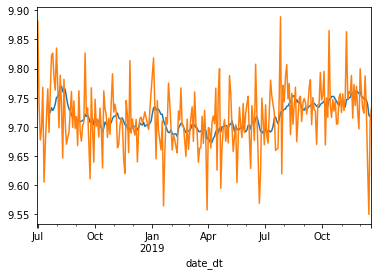

In [626]:
p_scaled.rolling(12).mean().plot(label='12 Month Rolling Mean')
#p_scaled.rolling(12).std().plot(label='12 Month Rolling Mean')
p_scaled.plot()

In [627]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(p_scaled)

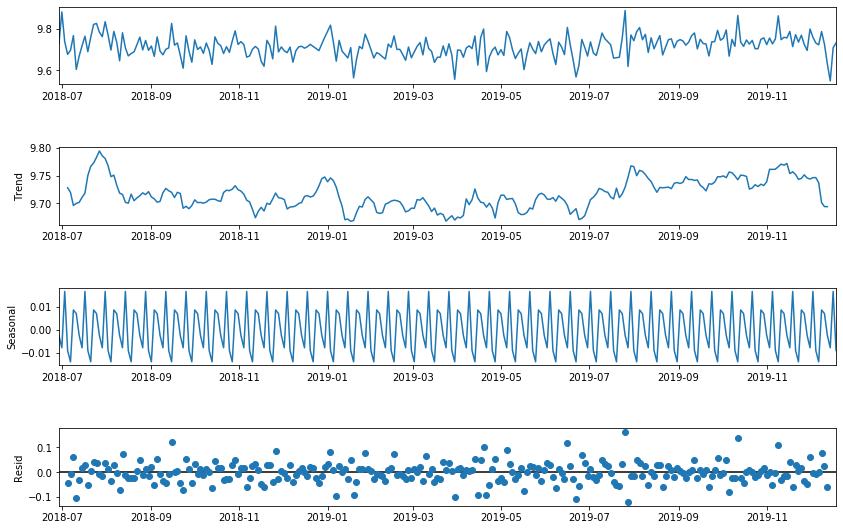

In [634]:
fig = decomp.plot()
fig.set_size_inches(13,8)
plt.show()

In [553]:
price = price.resample('W').mean()

In [554]:
price

date_dt
2012-12-23             NaN
2012-12-30             NaN
2013-01-06             NaN
2013-01-13             NaN
2013-01-20    47500.000000
                  ...     
2019-11-24    94183.806061
2019-12-01    94701.431034
2019-12-08    96150.432927
2019-12-15    94919.368421
2019-12-22    95366.880000
Freq: W-SUN, Name: price_sqm, Length: 366, dtype: float64

In [555]:
price

date_dt
2012-12-23             NaN
2012-12-30             NaN
2013-01-06             NaN
2013-01-13             NaN
2013-01-20    47500.000000
                  ...     
2019-11-24    94183.806061
2019-12-01    94701.431034
2019-12-08    96150.432927
2019-12-15    94919.368421
2019-12-22    95366.880000
Freq: W-SUN, Name: price_sqm, Length: 366, dtype: float64

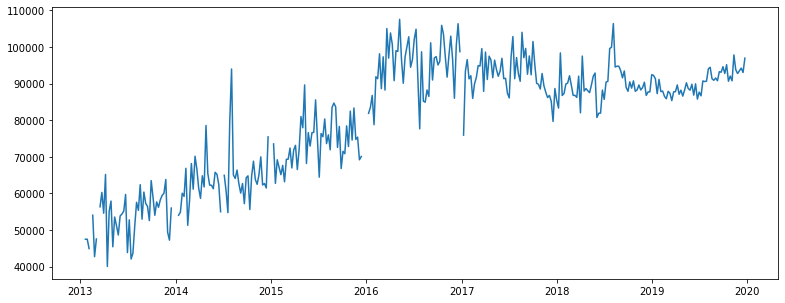

In [275]:
plt.figure(figsize=(13,5))
plt.plot(price.index, price)
plt.show()

In [74]:
num_dt = pd.to_numeric(df.date_dt)
num_dt = (num_dt - num_dt.min())/(num_dt.max() - num_dt.min())

In [76]:
df['time'] = num_dt

# Feature Engineering

In [469]:
df1 = df[['area', 'nbr_rooms', 'living_space', 'rent', 'additional', 'year_built', 'bi_area', 'time', 'closing_price']]

In [471]:
df1.loc[df1.bi_area.isna(),'bi_area'] = 0
df1.loc[df1.additional.isna(), 'additional'] = 0
#df1.loc[df1.rent.isna(), 'rent'] = 0

In [472]:
df1 = df1.loc[~df1.rent.isna()]

In [473]:
df1 = df1.loc[~df1.year_built.isna()]
df1 = df1.loc[(df1.year_built != 0) & (df1.year_built != 189.0)]

In [474]:
df1 = df1.loc[~df1.living_space.isna()]
df1 = df1.loc[~df1.nbr_rooms.isna()]

In [478]:
df1

,area,nbr_rooms,living_space,rent,additional,year_built,bi_area,time,closing_price
0,sodermalm,1.0,40.0,1160.0,9500.0,1889.0,0.0,1.000000,4100000
1,kungsholmen,1.0,22.0,1581.0,2800.0,1937.0,0.0,1.000000,2375000
2,vasastan,2.0,50.0,550.0,3600.0,1912.0,0.0,0.999608,5425000
3,kungsholmen,1.0,27.0,790.0,4164.0,1937.0,0.0,0.999608,2800000
4,lilla_essingen,3.0,84.0,3689.0,5500.0,1939.0,0.0,0.999608,5225000
...,...,...,...,...,...,...,...,...,...
14510,lilla_essingen,2.0,40.0,2464.0,0.0,1938.0,0.0,0.021143,2310000
14511,lilla_essingen,1.5,42.0,2436.0,6680.0,1936.0,0.0,0.019969,2115000
14515,stora_essingen,2.5,84.0,3732.0,9616.0,1935.0,0.0,0.014879,3775000
14516,lilla_essingen,1.5,40.0,2269.0,3400.0,1939.0,0.0,0.012529,1900000


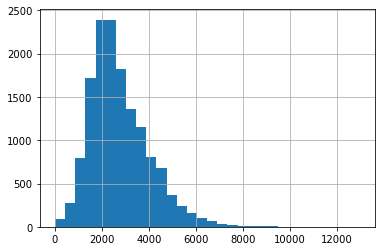

In [637]:
df.rent.hist(bins=30)

In [519]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
scaler = PowerTransformer(method='box-cox', standardize=False)
y_scaled = pd.DataFrame(scaler.fit_transform(df1[['closing_price']]+.000001))
y_scaled.columns = ['closing_price']

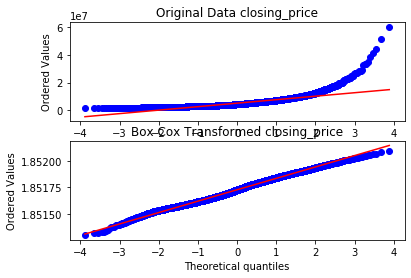

In [520]:
from scipy import stats
import matplotlib.pyplot as plt
for c in y_scaled.columns:
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    x = df1[c]
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Original Data {}'.format(c))
    ax2 = fig.add_subplot(212)
    xt = y_scaled[c]
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Box Cox Transformed {}'.format(c))
    plt.show()

In [547]:
df1

,nbr_rooms,living_space,rent,additional,year_built,bi_area,time,closing_price,area_gamla_stan,area_gardet,area_kungsholmen,area_lilla_essingen,area_ostermalm,area_sodermalm,area_stora_essingen,area_vasastan
0,1.0,40.0,1160.0,9500.0,1889.0,0.0,1.000000,4100000,0,0,0,0,0,1,0,0
1,1.0,22.0,1581.0,2800.0,1937.0,0.0,1.000000,2375000,0,0,1,0,0,0,0,0
2,2.0,50.0,550.0,3600.0,1912.0,0.0,0.999608,5425000,0,0,0,0,0,0,0,1
3,1.0,27.0,790.0,4164.0,1937.0,0.0,0.999608,2800000,0,0,1,0,0,0,0,0
4,3.0,84.0,3689.0,5500.0,1939.0,0.0,0.999608,5225000,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14510,2.0,40.0,2464.0,0.0,1938.0,0.0,0.021143,2310000,0,0,0,1,0,0,0,0
14511,1.5,42.0,2436.0,6680.0,1936.0,0.0,0.019969,2115000,0,0,0,1,0,0,0,0
14515,2.5,84.0,3732.0,9616.0,1935.0,0.0,0.014879,3775000,0,0,0,0,0,0,1,0
14516,1.5,40.0,2269.0,3400.0,1939.0,0.0,0.012529,1900000,0,0,0,1,0,0,0,0


In [550]:
price = y_scaled
price.index = df1.time
plt.plot(price.resample('W').mean())

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Float64Index'

# Feature Selection

In [524]:
df1 = pd.get_dummies(df1)

In [525]:
df1.corr()['closing_price'].sort_values(ascending=False)

closing_price          1.000000
living_space           0.901042
nbr_rooms              0.788367
rent                   0.597169
area_ostermalm         0.278363
bi_area                0.148146
additional             0.119461
time                   0.115276
area_vasastan          0.090350
area_gamla_stan        0.012618
year_built            -0.044024
area_gardet           -0.065098
area_kungsholmen      -0.071899
area_sodermalm        -0.072341
area_stora_essingen   -0.116096
area_lilla_essingen   -0.142939
Name: closing_price, dtype: float64

In [638]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1.drop('closing_price', axis=1),
                                                    df1.closing_price,
                                                    test_size=.3,
                                                    random_state=42)

In [639]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
fs_dict = {
    'Ridge' : Ridge(max_iter=10000),
    'Lasso' : Lasso(max_iter=10000, alpha=10),
    'Linear' : LinearRegression(),
    'RandomForest' : RandomForestRegressor(random_state=42)
    
}
for k in fs_dict.keys():
    fs_dict[k].fit(X_train, y_train)

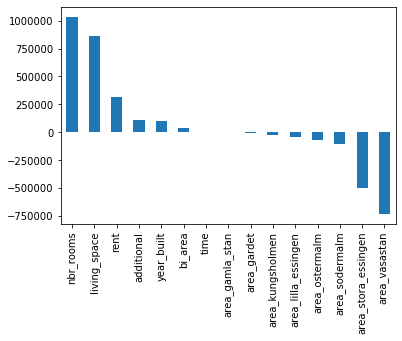

In [640]:
tra_col = X_train.columns
coef = pd.Series(fs_dict['Ridge'].coef_).sort_values(ascending=False)
coef.index = tra_col
coef.plot.bar()

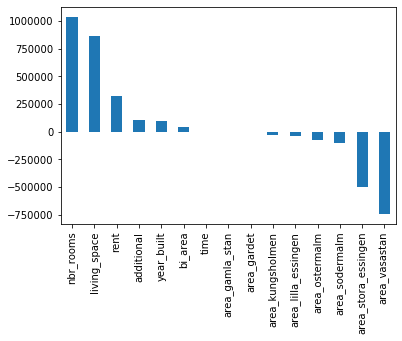

In [641]:
tra_col = X_train.columns
coef = pd.Series(fs_dict['Linear'].coef_).sort_values(ascending=False)
coef.index = tra_col
coef.plot.bar()

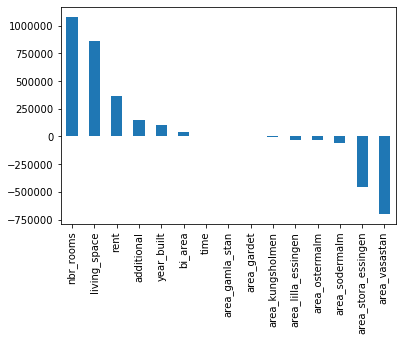

In [642]:
tra_col = X_train.columns
coef = pd.Series(fs_dict['Lasso'].coef_).sort_values(ascending=False)
coef.index = tra_col
coef.plot.bar()

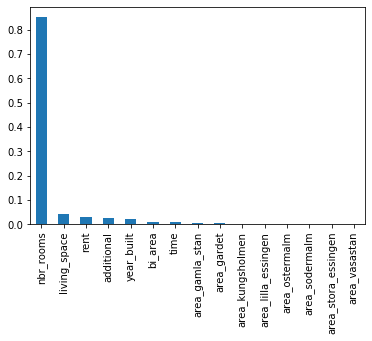

In [643]:
tra_col = X_train.columns
coef = pd.Series(fs_dict['RandomForest'].feature_importances_).sort_values(ascending=False)
coef.index = tra_col
coef.plot.bar()

In [645]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
y_true = y_test
scoring = {'mse' : mean_squared_error, 
           'mae' : mean_absolute_error, 
           'evs' : explained_variance_score, 
           'r2' : r2_score}
predictions = {}
score_dict = {}
for k in fs_dict.keys():
    score_dict[k] = {}
    y_pred = fs_dict[k].predict(X_test)
    predictions[k] = y_pred
    for m in scoring.keys():
        score_dict[k][m] = scoring[m](y_true, y_pred)
    

In [646]:
pd.DataFrame.from_dict(score_dict, orient='index').loc['RandomForest']

mse    1.119882e+12
mae    4.819229e+05
evs    8.702200e-01
r2     8.702007e-01
Name: RandomForest, dtype: float64

In [647]:
predictions

{'Ridge': array([5284851.94812371, 2759221.1311329 , 4938098.77752568, ...,
        3406482.62887933, 5686492.31103268, 3355067.29673244]),
 'Lasso': array([5286023.61827792, 2758920.9508154 , 4938357.73123317, ...,
        3406590.77728943, 5686524.75762531, 3354907.36187641]),
 'Linear': array([5286186.74275154, 2758960.98787598, 4938451.31974596, ...,
        3406624.66142306, 5686585.71582106, 3354954.13670756]),
 'RandomForest': array([5337150., 3495800., 4911500., ..., 3502110., 5489700., 3177150.])}

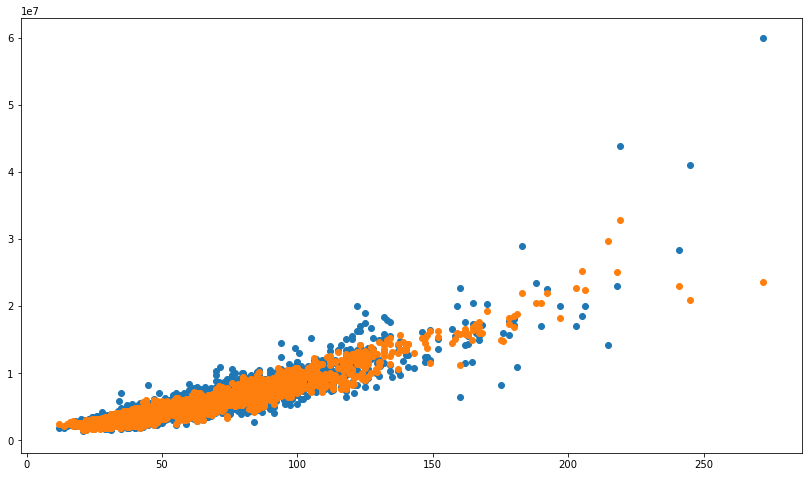

In [661]:
plt.figure(figsize=(14,8))
plt.scatter(X_test.living_space, y_true.values)
plt.scatter(X_test.living_space, predictions['RandomForest'])

In [649]:
np.mean(abs(predictions['RandomForest']-y_true.values))

481922.88289621554

,nbr_rooms,living_space,rent,additional,year_built,bi_area,time,area_gamla_stan,area_gardet,area_kungsholmen,area_lilla_essingen,area_ostermalm,area_sodermalm,area_stora_essingen,area_vasastan
6365,2.0,53.0,2337.0,9504.0,1917.0,0.0,0.889585,0,0,0,0,0,0,0,1
1046,3.0,70.0,2293.0,14520.0,1897.0,29.0,0.980031,0,0,0,0,0,0,0,1
5832,2.0,74.0,2940.0,0.0,1882.0,0.0,0.897807,0,0,0,0,0,0,0,1
7877,2.0,56.0,2800.0,3900.0,1947.0,0.0,0.856304,0,0,0,0,0,0,0,1
2195,1.0,23.0,881.0,3600.0,1880.0,0.0,0.964370,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5050,2.0,83.0,3213.0,5500.0,1880.0,0.0,0.911511,0,0,0,0,0,0,0,1
2507,3.0,71.0,4041.0,4640.0,2018.0,0.0,0.960454,0,0,0,0,0,0,0,1
5378,2.0,66.0,1153.0,0.0,1916.0,0.0,0.906421,0,0,0,0,0,0,0,1
5308,2.0,61.0,2601.0,4200.0,1929.0,0.0,0.907987,0,0,0,0,0,0,0,1


# Modeling With Keras

In [354]:
from keras.models import Sequential
from keras.layers import Dense
(_, input_shape) = X_train.shape
model = Sequential()
model.add(Dense(128, input_shape=(input_shape, ), activation='relu', name='dense_1'))
model.add(Dense(64, activation='relu', name='dense_2'))
model.add(Dense(32, activation='relu', name='dense_3'))
model.add(Dense(1, activation='linear', name='dense_output'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_output (Dense)         (None, 1)                 33        
Total params: 12,417
Trainable params: 12,417
Non-trainable params: 0
_________________________________________________________________


In [355]:
history = model.fit(X_train, y_train, 
          epochs=100,
          validation_split=0.1,
          batch_size=12)

Train on 8470 samples, validate on 942 samples
Epoch 1/100
8470/8470 [==============================] - 1s 108us/step - loss: 11709912562470.1426 - mae: 2302880.2500 - val_loss: 5260607274277.5029 - val_mae: 1564566.0000
Epoch 2/100
8470/8470 [==============================] - 1s 94us/step - loss: 4999926585869.6611 - mae: 1466198.0000 - val_loss: 4973134222225.1211 - val_mae: 1410269.6250
Epoch 3/100
8470/8470 [==============================] - 1s 112us/step - loss: 4856447718545.3193 - mae: 1439570.8750 - val_loss: 5365046484939.8213 - val_mae: 1454719.8750
Epoch 4/100
8470/8470 [==============================] - 1s 117us/step - loss: 4771656698299.4512 - mae: 1422808.5000 - val_loss: 5432154492380.1270 - val_mae: 1439299.1250
Epoch 5/100
8470/8470 [==============================] - 1s 93us/step - loss: 4686515180894.3604 - mae: 1412594.3750 - val_loss: 5836646265066.8027 - val_mae: 1446390.8750
Epoch 6/100
8470/8470 [==============================] - 1s 95us/step - loss: 46098873193

8470/8470 [==============================] - 1s 97us/step - loss: 970059761538.7505 - mae: 612192.0000 - val_loss: 1920203688496.9172 - val_mae: 642570.9375
Epoch 49/100
8470/8470 [==============================] - 1s 95us/step - loss: 991526319189.3535 - mae: 615829.0000 - val_loss: 1891050014237.3503 - val_mae: 668321.8125
Epoch 50/100
8470/8470 [==============================] - 1s 98us/step - loss: 979940476017.4016 - mae: 613592.4375 - val_loss: 1599940483398.1147 - val_mae: 629607.0625
Epoch 51/100
8470/8470 [==============================] - 1s 100us/step - loss: 974258707226.5369 - mae: 610206.9375 - val_loss: 1964364176520.9683 - val_mae: 648999.3125
Epoch 52/100
8470/8470 [==============================] - 1s 112us/step - loss: 977180832331.0773 - mae: 614117.0625 - val_loss: 2069738536020.7898 - val_mae: 677763.5625
Epoch 53/100
8470/8470 [==============================] - 1s 102us/step - loss: 974294433455.4219 - mae: 616200.6875 - val_loss: 1651636239862.2166 - val_mae: 64

8470/8470 [==============================] - 1s 92us/step - loss: 930764917245.2194 - mae: 596593.3750 - val_loss: 1702184639103.1848 - val_mae: 626131.0625
Epoch 97/100
8470/8470 [==============================] - 1s 94us/step - loss: 939741013188.5790 - mae: 602893.9375 - val_loss: 1573799482883.2612 - val_mae: 613627.3125
Epoch 98/100
8470/8470 [==============================] - 1s 92us/step - loss: 915078349587.2831 - mae: 595217.5000 - val_loss: 1653752496962.8535 - val_mae: 616862.1875
Epoch 99/100
8470/8470 [==============================] - 1s 97us/step - loss: 923701219131.6628 - mae: 593750.1250 - val_loss: 1606532919322.0891 - val_mae: 622191.5000
Epoch 100/100
8470/8470 [==============================] - 1s 95us/step - loss: 917404260181.2931 - mae: 586584.9375 - val_loss: 1969205741815.8472 - val_mae: 620587.3750


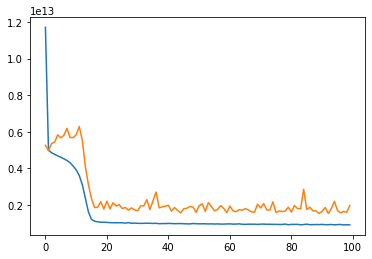

In [356]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(np.arange(len(loss)), loss)
plt.plot(np.arange(len(loss)), val_loss)
plt.show()

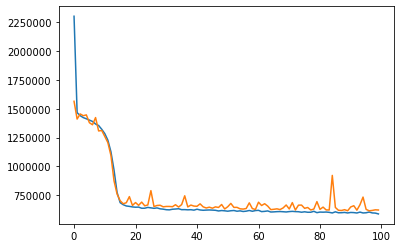

In [357]:
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(np.arange(len(mae)), mae)
plt.plot(np.arange(len(mae)), val_mae)
plt.show()

In [ ]:
# Not as good as Random Forest!

# Hyper Parameter Tune Random Forest

In [417]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [423]:
# Use the random grid to search for best hyperparameters
from sklearn.metrics import make_scorer
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 20, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42,
                               scoring='neg_mean_absolute_error',
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [424]:
tuned_model = rf_random.best_estimator_

In [425]:
scoring = {'mse' : mean_squared_error, 
           'mae' : mean_absolute_error, 
           'evs' : explained_variance_score, 
           'r2' : r2_score}
y_pred = tuned_model.predict(X_test)
model_scores = {}
for m in scoring.keys():
    model_scores[m] = scoring[m](y_true, y_pred)

In [428]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}